**Auteur** : Viktoriya Zeruk<br>
**Date dernière version** : 12/07/2022<br>

# <center><font color=#7DF9FF>Projet 5: <br>Catégorisez automatiquement des questions</font> </center>

<img src="https://user.oc-static.com/upload/2022/03/23/16480242457412_Screenshot%202022-03-23%20at%2009.30.21.png" alt="">

# <center><font color=#15f4ee> Modélisation de la prédiction de tags</font></center>

Ce notebook regroupe les travaux de prétraitement des docuements et les tests des modèles des approches supervisés et non supervisés afin de prédire les tags des posts de Stack Overflow.

## Contexte

Afin de permettre de faciliter le parcours des utilisateurs de l'outil communautaire Stack Overflow nous avons travaillé sur la mise à disposition d'un *système de suggestion de tags*.

## Importation des données

Pour les besoins du notebook nous ne conservons que les titres, corps du texte et tags des document importés. 

In [1]:
import pandas as pd
import numpy as np
import IPython.display

data = pd.read_csv('./data/filtered_data.csv', usecols=['Id','Title', 'Body', 'Tags'], index_col='Id')
data.reset_index(inplace=True)
data.drop(columns='Id', inplace=True)
data.head(10)

,Title,Body,Tags
0,Why is processing a sorted array faster than p...,<p>Here is a piece of C++ code that shows some...,<java><c++><performance><cpu-architecture><bra...
1,How do I undo the most recent local commits in...,<p>I accidentally <strong>committed the wrong ...,<git><version-control><git-commit><undo>
2,How do I delete a Git branch locally and remot...,<p>I want to delete a branch both locally and ...,<git><version-control><git-branch><git-push><g...
3,"How do I force ""git pull"" to overwrite local f...",<p>How do I force an overwrite of local files ...,<git><version-control><overwrite><git-pull><gi...
4,How do I revert a Git repository to a previous...,<p>How do I revert from my current state to a ...,<git><git-checkout><git-reset><git-revert>
5,How do I check out a remote Git branch?,<p>Somebody pushed a branch called <code>test<...,<git><git-checkout><remote-branch>
6,"How to make Git ""forget"" about a file that was...",<p>There is a file that was being tracked by <...,<git><gitignore><git-rm>
7,"What is the difference between ""px"", ""dip"", ""d...",<p>What is the difference between Android unit...,<android><android-layout><user-interface><dime...
8,How do I find all files containing specific te...,<p>I'm trying to find a way to scan my entire ...,<linux><text><grep><directory><find>
9,What is the difference between POST and PUT in...,"<p>According to <a href=""https://tools.ietf.or...",<http><rest><post><put>


## Pré-traitement

### Constitution du corpus 

Nous commençons par créer une nouvelle variable associant le titre (Title) et le corps du texte (Body)

In [2]:
%%time
data['Post'] = data.apply(lambda x: x['Title'] + ' ' + x['Body'] if x['Title'] == x['Title'] else x['Body'], axis=1)
corpus = data['Post'].to_list()
tags = data['Tags'].to_list()

print("Dix première observations")
display(data.head(10))

print("Premier élément de la liste corpus\n")
display(corpus[0])
print("\n")

print("Premier éléments de la liste tags\n")
display(tags[0])

print(f"Occurences dans le corpus: {len(corpus)}")
print(f"Occurences dans les tags: {len(tags)}")

Dix première observations


,Title,Body,Tags,Post
0,Why is processing a sorted array faster than p...,<p>Here is a piece of C++ code that shows some...,<java><c++><performance><cpu-architecture><bra...,Why is processing a sorted array faster than p...
1,How do I undo the most recent local commits in...,<p>I accidentally <strong>committed the wrong ...,<git><version-control><git-commit><undo>,How do I undo the most recent local commits in...
2,How do I delete a Git branch locally and remot...,<p>I want to delete a branch both locally and ...,<git><version-control><git-branch><git-push><g...,How do I delete a Git branch locally and remot...
3,"How do I force ""git pull"" to overwrite local f...",<p>How do I force an overwrite of local files ...,<git><version-control><overwrite><git-pull><gi...,"How do I force ""git pull"" to overwrite local f..."
4,How do I revert a Git repository to a previous...,<p>How do I revert from my current state to a ...,<git><git-checkout><git-reset><git-revert>,How do I revert a Git repository to a previous...
5,How do I check out a remote Git branch?,<p>Somebody pushed a branch called <code>test<...,<git><git-checkout><remote-branch>,How do I check out a remote Git branch? <p>Som...
6,"How to make Git ""forget"" about a file that was...",<p>There is a file that was being tracked by <...,<git><gitignore><git-rm>,"How to make Git ""forget"" about a file that was..."
7,"What is the difference between ""px"", ""dip"", ""d...",<p>What is the difference between Android unit...,<android><android-layout><user-interface><dime...,"What is the difference between ""px"", ""dip"", ""d..."
8,How do I find all files containing specific te...,<p>I'm trying to find a way to scan my entire ...,<linux><text><grep><directory><find>,How do I find all files containing specific te...
9,What is the difference between POST and PUT in...,"<p>According to <a href=""https://tools.ietf.or...",<http><rest><post><put>,What is the difference between POST and PUT in...


Premier élément de la liste corpus



'Why is processing a sorted array faster than processing an unsorted array? <p>Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data miraculously makes the code almost six times faster:</p>\n<pre class="lang-cpp prettyprint-override"><code>#include &lt;algorithm&gt;\n#include &lt;ctime&gt;\n#include &lt;iostream&gt;\n\nint main()\n{\n    // Generate data\n    const unsigned arraySize = 32768;\n    int data[arraySize];\n\n    for (unsigned c = 0; c &lt; arraySize; ++c)\n        data[c] = std::rand() % 256;\n\n    // !!! With this, the next loop runs faster.\n    std::sort(data, data + arraySize);\n\n    // Test\n    clock_t start = clock();\n    long long sum = 0;\n    for (unsigned i = 0; i &lt; 100000; ++i)\n    {\n        for (unsigned c = 0; c &lt; arraySize; ++c)\n        {   // Primary loop\n            if (data[c] &gt;= 128)\n                sum += data[c];\n        }\n    }\n\n    double elapsedTime = static_cast&lt;double&



Premier éléments de la liste tags



'<java><c++><performance><cpu-architecture><branch-prediction>'

Occurences dans le corpus: 35888
Occurences dans les tags: 35888
CPU times: total: 547 ms
Wall time: 627 ms


### Nettoyage HTML

Afin de traiter au mieux les données textuelles du `Body`, il est nécessaire de réaliser plusieurs tâches de data cleaning. Par exemple, le texte stocké dans cette variable est au format HTML. Ces balises vont polluer notre analyse. Nous allons donc **supprimer toutes les balises HTML** avec la librairie `BeautifulSoup` pour ne conserver que le texte brut.

Mais avant cette opération,nous allons supprimer tout le contenu placé entre 2 balises html `<code></code>`, cela nous permettra de supprimer tout le code brut souvent copié dans les questions Stackoverflow et qui pourrait avoir un fort impact pour la suite.

Nous constatons que les contenus importés comportent un nombre importante de balise HTML. Nous créeons une fonction afin de les retirer.

In [3]:
%%time

def clean_html(text):
    """
    Remove HTML from a text.
    
    Args:
        text(String): Row text with html 
             
    Returns:
        cleaned String
    """
    import lxml
    import html5lib
    from bs4 import BeautifulSoup
 
    soup = BeautifulSoup(text, "html5lib")

    for sent in soup(['style', 'script']):
            sent.decompose()
   
        
    return ' '.join(soup.stripped_strings)

corpus_wo_html = [clean_html(text) for text in corpus]

print("Premier élément de la liste corpus sans html\n")
display(corpus_wo_html[0])
print("\n")

print(f"Occurences dans le corpus: {len(corpus_wo_html)}")

Premier élément de la liste corpus sans html



'Why is processing a sorted array faster than processing an unsorted array? Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data miraculously makes the code almost six times faster: #include <algorithm>\n#include <ctime>\n#include <iostream>\n\nint main()\n{\n    // Generate data\n    const unsigned arraySize = 32768;\n    int data[arraySize];\n\n    for (unsigned c = 0; c < arraySize; ++c)\n        data[c] = std::rand() % 256;\n\n    // !!! With this, the next loop runs faster.\n    std::sort(data, data + arraySize);\n\n    // Test\n    clock_t start = clock();\n    long long sum = 0;\n    for (unsigned i = 0; i < 100000; ++i)\n    {\n        for (unsigned c = 0; c < arraySize; ++c)\n        {   // Primary loop\n            if (data[c] >= 128)\n                sum += data[c];\n        }\n    }\n\n    double elapsedTime = static_cast<double>(clock() - start) / CLOCKS_PER_SEC;\n\n    std::cout << elapsedTime << std::endl;\n    std



Occurences dans le corpus: 35888
CPU times: total: 50.1 s
Wall time: 50.3 s


### Nettoyage du texte

Pour les besoin des traitemment futurs et entrainements des modèles, nous avons besoins de passer les textes en minuscule. Nous en profitons pour ne conserver que les caractères alphabétiques et ne garder que les termes de plus de trois lettres. Le filtrage sur la taille des termes permet de retirer ceux qui sont générique liés au code (if, for …). Il  reste toutefois perfectible puisqu’il élimine les occurrences de certains langages (C, C++, C#, R… ). 

In [4]:
%%time

def text_cleaning(text):
    """
    Remove figures, punctuation, words shorter than two letters (excepted C or R) in a lowered text. 
    
    Args:
        text(String): Row text to clean
        
    Returns:
       res(string): Cleaned text
    """
    import re
    
    pattern = re.compile(r'[^\w]|[\d_]')
    
    try: 
        res = re.sub(pattern," ", text).lower()
    except TypeError:
        return text
    
    res = res.split(" ")
    res = list(filter(lambda x: len(x)>3 , res))
    res = " ".join(res)
    return res

cleaned_corpus = [text_cleaning(text) for text in corpus_wo_html]
cleaned_tags = [text_cleaning(text).strip() for text in tags]


print("Premier élément de la liste cleaned_corpus\n")
display(cleaned_corpus[0])
print("\n")

print("Premier élément de la liste cleaned_tags\n")
display(cleaned_tags[0])
print("\n")

print(f"Occurences dans le corpus nettoyé: {len(cleaned_corpus)}")
print(f"Occurences dans les tags nettoyés: {len(cleaned_tags)}")

Premier élément de la liste cleaned_corpus



'processing sorted array faster than processing unsorted array here piece code that shows some very peculiar behavior some strange reason sorting data miraculously makes code almost times faster include algorithm include ctime include iostream main generate data const unsigned arraysize data arraysize unsigned arraysize data rand with this next loop runs faster sort data data arraysize test clock start clock long long unsigned unsigned arraysize primary loop data data double elapsedtime static cast double clock start clocks cout elapsedtime endl cout endl without sort data data arraysize code runs seconds with sorted data code runs seconds initially thought this might just language compiler anomaly tried java import java util arrays import java util random public class main public static void main string args generate data arraysize data arraysize random random arraysize data nextint with this next loop runs faster arrays sort data test long start system nanotime long arraysize primary



Premier élément de la liste cleaned_tags



'java performance architecture branch prediction'



Occurences dans le corpus nettoyé: 35888
Occurences dans les tags nettoyés: 35888
CPU times: total: 6.28 s
Wall time: 6.3 s


### Tokenization

La tokenisation permet de transformer les textes passés en entrée en liste de termes distincts (token).  Pendant le traitement les termes génériques (stop words) ne sont pas conservés dans la liste des tokens.

In [5]:
%%time
def tokenize(text):
    """
    Tokenize words of a text.
    
    Args:
    
        text(String): Row text
        
    Returns
    
        res(list): Tokenized string.
    """
    
    from nltk.corpus import stopwords
    from nltk import word_tokenize
    from nltk.tokenize import sent_tokenize

    stop_words = set(stopwords.words('english'))
    
    try:
        res = word_tokenize(text, language='english')
    except TypeError:
        return text
    
    res = [token for token in res if token not in stop_words]
    return res

tokenized_corpus = [tokenize(text) for text in cleaned_corpus]
tokenized_tags = [tokenize(text) for text in cleaned_tags]

print("Premier élément de la liste tokenized_corpus\n")
display(tokenized_corpus[0])
print("\n")
print(f"Longueur du premier éléments de liste tokenized_corpus: {len(tokenized_corpus[0])}")
print("\n")

print("Premier élément de la liste tokenized_tags\n")
display(tokenized_tags[0])
print('\n')


print(f"Occurences dans le corpus tokenizé: {len(tokenized_corpus)}")
print(f"Occurences dans la liste des tags: {len(tokenized_tags)}")

Premier élément de la liste tokenized_corpus



['processing',
 'sorted',
 'array',
 'faster',
 'processing',
 'unsorted',
 'array',
 'piece',
 'code',
 'shows',
 'peculiar',
 'behavior',
 'strange',
 'reason',
 'sorting',
 'data',
 'miraculously',
 'makes',
 'code',
 'almost',
 'times',
 'faster',
 'include',
 'algorithm',
 'include',
 'ctime',
 'include',
 'iostream',
 'main',
 'generate',
 'data',
 'const',
 'unsigned',
 'arraysize',
 'data',
 'arraysize',
 'unsigned',
 'arraysize',
 'data',
 'rand',
 'next',
 'loop',
 'runs',
 'faster',
 'sort',
 'data',
 'data',
 'arraysize',
 'test',
 'clock',
 'start',
 'clock',
 'long',
 'long',
 'unsigned',
 'unsigned',
 'arraysize',
 'primary',
 'loop',
 'data',
 'data',
 'double',
 'elapsedtime',
 'static',
 'cast',
 'double',
 'clock',
 'start',
 'clocks',
 'cout',
 'elapsedtime',
 'endl',
 'cout',
 'endl',
 'without',
 'sort',
 'data',
 'data',
 'arraysize',
 'code',
 'runs',
 'seconds',
 'sorted',
 'data',
 'code',
 'runs',
 'seconds',
 'initially',
 'thought',
 'might',
 'language',
 



Longueur du premier éléments de liste tokenized_corpus: 196


Premier élément de la liste tokenized_tags



['java', 'performance', 'architecture', 'branch', 'prediction']



Occurences dans le corpus tokenizé: 35888
Occurences dans la liste des tags: 35888
CPU times: total: 33.1 s
Wall time: 33.7 s


NLTK propose des listes de stop words génériques. Nous attirons  l’attention sur le fait que le corpus utilisé pour les travaux est de nature spécifique. En effet les posts contiennent souvent du code, des messages d’erreur de compilateurs / interpréteurs ou des logs alors qu’aucune liste de stop words mis à disposition ne porte sur le thématique. Le risque est de laisser passer des termes génériques vis-à-vis du contexte étudié. Sans allouer un important temps de travail il s’avère difficile de construire une liste de stop words spécifique exhaustive. 

### Filtrage des noms à l'aide d'un modèle de POS tagging

Lors de pré-traitement des posts nous cherchons avant tout à identifier à termes liés à des technologies utilisées. Ces dernières sont généralement des noms. Afin de mettre en œuvre le filtrage nous utilisons un modèle de POS. Ce dernier se base sur des chaînes de Markov . Leur principe est d’identifier la probabilité  la plus forte de la fonction grammaticale d’un terme par rapport :
- la fonction grammaticale du terme précédent 
- A la probabilité la plus forte de l’association entre le terme et une fonction grammaticale particulière


In [6]:
%%time 
def filtering_nouns(tokens):
    """
    Filter singular nouns
    
    Args:
        tokens(list): A list o tokens
        
    
    Returns:
    
        res(list): Filtered token list
    """ 
    
    import nltk
    
    res = nltk.pos_tag(tokens)
    
    res = [token[0] for token in res if token[1] == 'NN']
    
    return res

noun_corpus = [filtering_nouns(tokens) for tokens in tokenized_corpus]

print("Premier élément de la liste noun_corpus\n")
display(noun_corpus[0])
print("\n")

print(f"Longueur du premier éléments de liste noun_corpus: {len(noun_corpus[0])}")
print("\n")


print(f"Occurences dans le corpus tokenizé: {len(noun_corpus)}")

Premier élément de la liste noun_corpus



['processing',
 'processing',
 'array',
 'piece',
 'code',
 'reason',
 'code',
 'generate',
 'const',
 'arraysize',
 'arraysize',
 'arraysize',
 'loop',
 'sort',
 'test',
 'clock',
 'start',
 'clock',
 'arraysize',
 'loop',
 'cast',
 'clock',
 'start',
 'cout',
 'elapsedtime',
 'endl',
 'cout',
 'endl',
 'sort',
 'arraysize',
 'code',
 'code',
 'language',
 'java',
 'import',
 'java',
 'java',
 'class',
 'void',
 'string',
 'generate',
 'arraysize',
 'nextint',
 'loop',
 'test',
 'system',
 'loop',
 'system',
 'println',
 'system',
 'start',
 'system',
 'result',
 'processing',
 'processing',
 'array',
 'code',
 'order',
 'matter',
 'effect',
 'array',
 'speed',
 'processing',
 'clang',
 'optimization',
 'flag',
 'code']



Longueur du premier éléments de liste noun_corpus: 67


Occurences dans le corpus tokenizé: 35888
CPU times: total: 3min 3s
Wall time: 3min 3s


Nous attirons une nouvelle fois l’attention sur le fait que le corpus utilisé pour les travaux est de nature spécifique. Aucun corpus mis à disposition par NLTK ne couvre le domaine étudié. Le risque est que certaines technologies, dont la dénomination ne découle pas d’un nom commun, ne soient pas retenues par  le filtre.

### Lemmatisation

Afin d’éviter d’utiliser de multiples déclinaisons d’un même terme (conjugaisons, féminin, pluriel …). Les deux méthodes les couramment utilisées sont le stemming et la lemmatisation. Elles consistent toutes deux à dédupliquer les déclinaisons de termes en ne conservant que leur racine. Le stemming procède par troncature simple. De manière générale cette méthode peut poser un problème car plusieurs mots termes sémantiquement différents peuvent avoir la même racine (stem). La lemmatisation  consiste à identifier la racine sémantique (lemme) d’un terme référencé dans un corpus ou un dictionnaire d’une langue. Cette méthode évite, a priori, l’écueil de diminuer le nombre de termes ayant un stem identique mais des lemmes différents. Nous retenons donc la lemmatisation.  Par contre une fois encore nous sommes confrontés à la généricité des outils mis à disposition par NLTK. A titre d’exemple, “keras” (Framework de deep learning) devient “kera” une fois lemmatisé.

In [7]:
%%time
def lemmatization(tokens):
    """
    Transform tokens into lems 
    
    Args:
        tokens(list): List of tokens
        
    Returns:
        lemmatized(list): List of lemmatized tokens
    """
    import nltk
    from nltk.stem import WordNetLemmatizer
    
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    
    for token in tokens:
        lemmatized.append(lemmatizer.lemmatize(token))
        
    return lemmatized

lemmatized_corpus = [lemmatization(tokens) for tokens in noun_corpus]
lemmatized_tags = [lemmatization(tokens) for tokens in tokenized_tags]

tags_wo_blanks = []
for tokens in lemmatized_tags:
    tokens = [token for token in tokens if len(token)>1]
    tags_wo_blanks.append(tokens)

print("Premier élément de la liste lemmatized_corpus\n")
display(lemmatized_corpus[0])
print("\n")

print(f"Longueur du premier éléments de liste lemmatized_corpus: {len(lemmatized_corpus[0])}")
print("\n")

print("Premier élément de la liste lemmatized_tags\n")
display(tags_wo_blanks[0])


print(f"Occurences dans le corpus lemmatisé: {len(lemmatized_corpus)}")
print(f"Occurences dans les tags lemmatisés: {len(tags_wo_blanks)}")

Premier élément de la liste lemmatized_corpus



['processing',
 'processing',
 'array',
 'piece',
 'code',
 'reason',
 'code',
 'generate',
 'const',
 'arraysize',
 'arraysize',
 'arraysize',
 'loop',
 'sort',
 'test',
 'clock',
 'start',
 'clock',
 'arraysize',
 'loop',
 'cast',
 'clock',
 'start',
 'cout',
 'elapsedtime',
 'endl',
 'cout',
 'endl',
 'sort',
 'arraysize',
 'code',
 'code',
 'language',
 'java',
 'import',
 'java',
 'java',
 'class',
 'void',
 'string',
 'generate',
 'arraysize',
 'nextint',
 'loop',
 'test',
 'system',
 'loop',
 'system',
 'println',
 'system',
 'start',
 'system',
 'result',
 'processing',
 'processing',
 'array',
 'code',
 'order',
 'matter',
 'effect',
 'array',
 'speed',
 'processing',
 'clang',
 'optimization',
 'flag',
 'code']



Longueur du premier éléments de liste lemmatized_corpus: 67


Premier élément de la liste lemmatized_tags



['java', 'performance', 'architecture', 'branch', 'prediction']

Occurences dans le corpus lemmatisé: 35888
Occurences dans les tags lemmatisés: 35888
CPU times: total: 6.92 s
Wall time: 6.96 s


### Filtrage des valeurs vides

Les premiers traitements on généré des docuements vides. Nous décidons de filtrer le corpus pour les éliminer.

In [8]:
print(f"Observations restante du corpus original: {data.shape[0]}")

joined_corpus = [" ".join(text) for text in lemmatized_corpus]
corpus_df = pd.DataFrame(joined_corpus, columns=['preprocessed_text'])
corpus_df['len_text'] = corpus_df['preprocessed_text'].apply(lambda x: len(x))

joined_tags = [" ".join(tags) for tags in tags_wo_blanks]
tag_df = pd.DataFrame(joined_tags, columns=['preprocessed_tags'])
tag_df['len_tags'] = tag_df['preprocessed_tags'].apply(lambda x: len(x))

corpus_tag_df = pd.concat([corpus_df, tag_df], axis=1)

empty_data_idx = corpus_tag_df[(corpus_tag_df['len_text']==0) | (corpus_tag_df['len_tags']==0)].index

corpus_tag_df.drop(index=empty_data_idx, inplace=True)
data.drop(index=empty_data_idx, inplace=True)

print(f"observations restantes du corpus traité: {corpus_tag_df.shape[0]}")

corpus_tag_df['splitted_text'] = corpus_tag_df['preprocessed_text'].apply(lambda x: x.split(' ') )
corpus_tag_df['splitted_tags'] = corpus_tag_df['preprocessed_tags'].apply(lambda x: x.split(' ') )

filtered_corpus = corpus_tag_df['splitted_text'].to_list()
filtered_tags = corpus_tag_df['splitted_tags'].to_list()
filtered_original_posts = data['Post'].to_list()

filtered_tokenized_vs_original = pd.concat([data['Post'],
                                            corpus_tag_df['splitted_text'], 
                                            corpus_tag_df['splitted_tags']],
                                            axis=1)

filtered_tokenized_vs_original.to_csv("./data/cleaned_corpus.csv", index=False)
filtered_tokenized_vs_original.to_pickle('./data/cleaned_corpus.pkl')

filtered_tokenized_vs_original.head(10)

Observations restante du corpus original: 35888
observations restantes du corpus traité: 34473


,Post,splitted_text,splitted_tags
0,Why is processing a sorted array faster than p...,"[processing, processing, array, piece, code, r...","[java, performance, architecture, branch, pred..."
1,How do I undo the most recent local commits in...,"[commit, server, repository]","[version, control, commit, undo]"
2,How do I delete a Git branch locally and remot...,"[branch, branch, branch, branch, bugfix, error...","[version, control, branch, push, remote]"
3,"How do I force ""git pull"" to overwrite local f...","[force, pull, scenario, team, member, source, ...","[version, control, overwrite, pull, fetch]"
4,How do I revert a Git repository to a previous...,"[repository, commit, revert, state, snapshot, ...","[checkout, reset, revert]"
5,How do I check out a remote Git branch? <p>Som...,"[check, branch, somebody, branch, test, push, ...","[checkout, remote, branch]"
6,"How to make Git ""forget"" about a file that was...","[forget, file, file, gitignore, list, status, ...",[gitignore]
7,"What is the difference between ""px"", ""dip"", ""d...","[difference, difference, measure]","[android, android, layout, user, interface, di..."
8,How do I find all files containing specific te...,"[text, linux, linux, system, clarify, text, fi...","[linux, text, grep, directory, find]"
9,What is the difference between POST and PUT in...,"[difference, post, http, post, create, resourc...","[http, rest, post]"


### Fréquence de distribution tokens

Nous observons à présent la fréquence de distribution des tokens.

In [9]:
%%time
def build_word_distribution(corpus):
    """
    Build corpus word distribution
    
    Args:
        Corpus(List of lists): Original corpus
    
    Returns:
        
        word_dist_df(DataFrame): Word distribution of the corpus
    """
    
    from nltk import FreqDist
    word_corpus = [token for token_list in corpus for token in token_list]
    word_dist = FreqDist(word_corpus)
    word_dist_df = pd.DataFrame(word_dist.items(), columns=['Word', 'Frequency']).set_index('Word')
    word_dist_df.sort_values("Frequency", ascending=False, inplace=True)

    return word_dist_df

word_dist = build_word_distribution(filtered_corpus)

print(f"Nombre de tokens du corpus {word_dist.shape[0]}")
print("Affichage des 20 tokens les plus utilisés")
display(word_dist.head(20))

Nombre de tokens du corpus 86066
Affichage des 20 tokens les plus utilisés


,Frequency
Word,
java,33174
error,23288
class,22088
name,19479
file,19187
code,18638
function,14979
value,13735
http,13319


CPU times: total: 938 ms
Wall time: 980 ms


Nous constatons un nombre important de termes génériques tels que : error, class, value, return ...

### Fréquence de distribution des tags

Nous réalisons le même traitement sur les tags.

In [10]:
tag_dist = build_word_distribution(filtered_tags)
print("Top 20 des tags les plus utilisés")
display(tag_dist.head(20))
print(f"Nombre de tags: {len(tag_dist)}")
first_200_tags = tag_dist[0:200].index.to_list()

Top 20 des tags les plus utilisés


,Frequency
Word,
android,5652
java,4450
javascript,4207
python,3988
html,2027
jquery,1708
studio,1433
angular,1117
visual,1088


Nombre de tags: 5799


### filtrage top 200 tags

Pour les besoin des entrainements des modèles supervisés, nous avons besoin limiter le nombre de tags. Nous décidons de ne retenir que les 200 premiers.Du nous avons du à nouveau filtrer les documents qui ne sont pas liés aux 200 premiers tags.

In [11]:
print(f"Observations restantes dans le corpus original: {data.shape[0]}")
filtered_corpus_tag_df = corpus_tag_df.copy()
filtered_corpus_tag_df['tags_in_top200'] = filtered_corpus_tag_df['splitted_tags'].apply(lambda tags: [tag for tag in tags if tag in first_200_tags])

filtered_corpus_tag_df['len_tags_in_top200'] = filtered_corpus_tag_df['tags_in_top200'].apply(lambda x: len(x))
missing_filtered_data = filtered_corpus_tag_df[filtered_corpus_tag_df['len_tags_in_top200'] == 0].index

filtered_corpus_tag_df.drop(index=missing_filtered_data, inplace=True)
data.drop(index=missing_filtered_data, inplace=True)
print(f"Observations restantes dans le coprus traité: {filtered_corpus_tag_df.shape[0]}")

top200_corpus = filtered_corpus_tag_df['splitted_text'].to_list()
top200_joined_corpus = filtered_corpus_tag_df['preprocessed_text'].to_list()
top200_tags = filtered_corpus_tag_df['tags_in_top200'].to_list()

Observations restantes dans le corpus original: 34473
Observations restantes dans le coprus traité: 30933


### Fréquences de distribution des tokens après filtrage du top 200 tags

Nous souhaitons à nouveau appréhender la distribution des tokens sur le corpus filtré.

In [12]:
word_dist_top200 = build_word_distribution(top200_corpus)
print(f"Nombre de tokens du corpus {word_dist_top200.shape[0]}")
print("Affichage des 20 tokens les plus utilisés")
display(word_dist_top200.head(20))
print("Nombre des tokens ayant plus de 1000 occurences sur le corpus filtré")
word_dist_top200[word_dist_top200["Frequency"]>=1000].shape[0]

Nombre de tokens du corpus 80459
Affichage des 20 tokens les plus utilisés


,Frequency
Word,
java,32981
error,21303
class,20501
name,18046
file,17454
code,16824
function,13942
android,12980
http,12363


Nombre des tokens ayant plus de 1000 occurences sur le corpus filtré


300

Nous constaton que le filtrage par top 200 tags a changé le classement des tokens les plus représenté. De plus un filtrage par fréquence des token a drastiquement le nombre de tokens retenus.

### Fréquences de distribution des tags après filtrage du top 200 tags

Nous réalisons le même traitement sur les tags.

In [13]:
tag_dist_top_200 = build_word_distribution(top200_tags)
print("Top 20 des tags les plus utilisés")
display(tag_dist_top_200.head(20))
print(f"Nombre de tags: {len(tag_dist_top_200)}")

Top 20 des tags les plus utilisés


,Frequency
Word,
android,5652
java,4450
javascript,4207
python,3988
html,2027
jquery,1708
studio,1433
angular,1117
visual,1088


Nombre de tags: 200


### TF-IDF

Afin de pouvoir entraîner les modèles nous avons besoin de transformer les listes de tokens lemmatisés en vecteurs. Deux méthodes sont couramment utilisées :
- Bag of words : Chaque liste de token (appelée document) est transformée en un vecteur indiquant la fréquence brute de chaque terme du corpus dans la liste. 
- TF-IDF : Dans cette méthode, la fréquence brute d’un token  est remplacée par un indicateur composé de sa fréquence d’apparition du token dans le document et la fréquence inverse du nombre de documents où le token apparaît. Tel que TF-IDF=TF ×log⁡〖|D|/|{d_j ∶ t_i∈d_j }| 〗 avec |D| : le nombre total de documents dans le corpus et |{d_j ∶ t_i∈d_j }| : le nombre de documents ou le token apparaît. Cette méthode permet de minorer les tokens présents dans un nombre élevé de documents et de normaliser la taille des documents. 
Les documents contenant des termes très génériques et de longueurs très variables, nous avons décidé d’utiliser une vectorisation par TF-IDF pour la suite des travaux. Afin de de ne garder que les tokens les plus représentatifs, nous avons entrainé les modèles de vectorisation sur des dictionnaire de correspondance (vocabulary) ne comportant que des termes dont la fréquence est supérieure à 1000 occurrences dans le corpus.

In [14]:
%%time
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
vocabulary = list(word_dist_top200[word_dist_top200["Frequency"]>=1000].index)
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary)
X = tfidf_vectorizer.fit_transform(top200_joined_corpus)
tfidf_data = pd.DataFrame(X.toarray(), columns=vocabulary)
print("Affichage des 10 premiers posts vectorisés via le modèle de TF-IDF")
display(tfidf_data.head(10))
print(f" Nombre d'observations: {tfidf_data.shape[0]}, nombre de variables: {tfidf_data.shape[1]}")

filename_tfidf_model = './models/tfidf_model.pkl'
pickle.dump(tfidf_vectorizer, open(filename_tfidf_model, 'wb'))

filename_vocabulary = "./models/vocabulary.pkl"
pickle.dump(vocabulary, open(filename_vocabulary, 'wb'))

Affichage des 10 premiers posts vectorisés via le modèle de TF-IDF


,java,error,class,name,file,code,function,android,http,value,...,frame,parameter,zygoteinit,annotation,storage,development,byte,dialog,gradle,fragment
0,0.262283,0.000000,0.072405,0.000000,0.000000,0.358282,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.383837,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.155654,0.000000,0.000000,0.174871,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.150818,0.429448,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.109536,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.435691,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 Nombre d'observations: 30933, nombre de variables: 300
CPU times: total: 969 ms
Wall time: 1.02 s


## Entrainement des modèles en approche supervisée.

### Dédoublonnage des labels

Le dédoublonnage des tags – label s’avère nécessaire après le pré-traitement des documents. En effet, il n’est pas rare que les utilisateurs spécifient plusieurs versions d’une même technologie dans leurs tags. Après traitement préalable, notamment avec la suppression des caractères numérique, les tags-label peuvent contenir des doublons pour un même document. 

In [15]:
dedup_tags = []
for tags in top200_tags:
    dedup_tags.append(set(tags))

print('Affichage de la première occurence de dedup_tags')
display(dedup_tags[0])

Affichage de la première occurence de dedup_tags


{'java', 'performance'}

### Partition des données

Nous conservons 80% des données pour le jeu d’entraînement et 20% pour le jeu de test. 

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_data, dedup_tags, test_size=0.2, random_state=42)

### Réduction des données

La vectorisation a transformé les documents en un vecteur de  456 composantes. Afin de casser les corrélations entre celles-ci et optimiser le temps d’entrainement des modèles en réduisant les dimensions nous réalisons une ACP (Analyse en Composantes Principales).

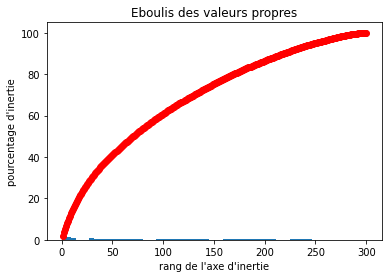

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(random_state=42)
pca.fit(X_train)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

display_scree_plot(pca)

A défaut d’un coude significatif dans la visualisation l’éboulis des composantes principales, nous utilisons un hyper paramètre consistant à retenir un nombre de vecteurs permettant de conserver 85% d’inertie.

In [18]:
import pickle 

pca = PCA(n_components=0.85, random_state=42)
pca.fit(X_train)
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)
print(f"Nombre de composantes principales: {pca.components_.shape[0]}")

filename_pca_model = './models/pca_model.pkl'
pickle.dump(pca, open(filename_pca_model, 'wb'))

Nombre de composantes principales: 193


### Vectorisaton des labels

A l’image des documents nous avons besoin de vectoriser les tags – labels afin d’entrainer les modèles. Scikit-learn fournit un module permettant de prendre en charge l’opération.

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle 

mlb = MultiLabelBinarizer(classes=first_200_tags)
train_labels = mlb.fit_transform(y_train)
test_labels = mlb.transform(y_test)

print("Affichage des classes du modèle de vectorisation")
display(mlb.classes_)

filename_mlb_model = './models/mlb_model.pkl'
pickle.dump(mlb, open(filename_mlb_model,'wb'))

Affichage des classes du modèle de vectorisation


array(['android', 'java', 'javascript', 'python', 'html', 'jquery',
       'studio', 'angular', 'visual', 'spring', 'google', 'server',
       'mysql', 'window', 'swift', 'node', 'xcode', 'array', 'string',
       'json', 'linux', 'core', 'ruby', 'laravel', 'file', 'performance',
       'reactjs', 'framework', 'algorithm', 'angularjs', 'objective',
       'service', 'docker', 'react', 'chrome', 'typescript', 'bash',
       'http', 'macos', 'regex', 'django', 'entity', 'bootstrap',
       'firebase', 'database', 'apache', 'gradle', 'eclipse', 'amazon',
       'image', 'rail', 'data', 'iphone', 'code', 'twitter', 'excel',
       'memory', 'maven', 'ajax', 'list', 'function', 'panda', 'flutter',
       'ubuntu', 'multithreading', 'design', 'boot', 'internet', 'date',
       'explorer', 'oracle', 'native', 'postgresql', 'testing', 'form',
       'class', 'loop', 'exception', 'numpy', 'security', 'azure', 'type',
       'language', 'pointer', 'layout', 'github', 'selenium', 'math',
       '

### Fonction d'évaluation des modèles

Afin de comparer les modèles nous avons évalué quatre indicateurs :
- Jaccard : l'indice et la distance de Jaccard sont deux métriques utilisées en statistiques pour comparer la similarité et la diversité (en) entre des échantillons.
- Précision : capacité à prédire correctement les tags associés à chaque document
- Recall : capacité à retourner pour chaque tags tous les documents qui y sont associés
- F1 Score : moyenne harmonique de ces deux indicateurs

Etant face à une classification multi-classes nous utilisons les version micro de ces indicateurs. Concrètement, cette version des indicateurs est calculée par classe puis agrégés là où les indicateurs macro sont calculés globalement. Lors de l’évaluation nous nous intéressons à la précision et au temps d’entraînement. Dans le cadre d’une API de suggestion de tags, la capacité d’un modèle à retourner tous les documents associés à chaque terme n’est pas essentielle. Le recall et le F1 score seront toutefois été observés pour affiner l’analyse. 


In [20]:
from sklearn.metrics import jaccard_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

models_performance = {}

def metrics_report(model_name, test_labels, predictions, performances):
    """
    Compute performance metrics of a model and store them in a dictionary
    
    Args:
        model_name(string): name of the evaluated model
        test_labels(array): labels related to predictors
        preductions(array): predicted results
        performances(dict): used dictionary to store metrics
    Returns:
        performances(dict): used dictionary to store metrics filed with models ones
    """    
    jaccard = jaccard_score(test_labels, predictions, average='macro')
    accuracy = accuracy_score(test_labels, predictions)
    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + model_name + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(jaccard, accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    
    performances[model_name] = {}
    performances[model_name]["jaccard"] =  jaccard
    performances[model_name]["micro_precision"] =  micro_precision
    performances[model_name]["micro_recall"] = micro_recall
    performances[model_name]["micro_f1"] = micro_f1
    
    return performances

### KNN

In [21]:
%%time
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_transformed, train_labels)
knn_predictions = knn_clf.predict(X_test_transformed)
metrics_report("knn", test_labels, knn_predictions, models_performance)

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------knn Model Metrics-----
Accuracy: 0.1047
Hamming Loss: 0.1123
Precision:
  - Macro: 0.0090
  - Micro: 0.3643
Recall:
  - Macro: 0.6521
  - Micro: 0.1227
F1-measure:
  - Macro: 0.2206
  - Micro: 0.1623
CPU times: total: 23.9 s
Wall time: 21.1 s


{'knn': {'jaccard': 0.1047386119063031,
  'micro_precision': 0.6520593869731801,
  'micro_recall': 0.22055726551109672,
  'micro_f1': 0.3296211112456119}}

### SVM

In [22]:
%%time
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svm_clf.fit(X_train_transformed, train_labels)

svm_preds = svm_clf.predict(X_test_transformed)
metrics_report("svm", test_labels, svm_preds, models_performance)

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------svm Model Metrics-----
Accuracy: 0.1064
Hamming Loss: 0.1450
Precision:
  - Macro: 0.0080
  - Micro: 0.2842
Recall:
  - Macro: 0.8056
  - Micro: 0.1198
F1-measure:
  - Macro: 0.2655
  - Micro: 0.1523
CPU times: total: 1.95 s
Wall time: 24.7 s


{'knn': {'jaccard': 0.1047386119063031,
  'micro_precision': 0.6520593869731801,
  'micro_recall': 0.22055726551109672,
  'micro_f1': 0.3296211112456119},
 'svm': {'jaccard': 0.10640343918322688,
  'micro_precision': 0.8056033423445564,
  'micro_recall': 0.2655110967114855,
  'micro_f1': 0.39939080109655806}}

### Random Forest

In [23]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train_transformed, train_labels)
rf_preds = rf_clf.predict(X_test_transformed)
metrics_report("Random Forest", test_labels, rf_preds, models_performance)

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------Random Forest Model Metrics-----
Accuracy: 0.0328
Hamming Loss: 0.0826
Precision:
  - Macro: 0.0088
  - Micro: 0.1952
Recall:
  - Macro: 0.8749
  - Micro: 0.0338
F1-measure:
  - Macro: 0.1388
  - Micro: 0.0519
CPU times: total: 26min 14s
Wall time: 5min 8s


{'knn': {'jaccard': 0.1047386119063031,
  'micro_precision': 0.6520593869731801,
  'micro_recall': 0.22055726551109672,
  'micro_f1': 0.3296211112456119},
 'svm': {'jaccard': 0.10640343918322688,
  'micro_precision': 0.8056033423445564,
  'micro_recall': 0.2655110967114855,
  'micro_f1': 0.39939080109655806},
 'Random Forest': {'jaccard': 0.03276138118251846,
  'micro_precision': 0.8749361919346605,
  'micro_recall': 0.13883039040984935,
  'micro_f1': 0.23963649073750437}}

### Gradient boosting

In [24]:
'''%%time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

gb_clf = OneVsRestClassifier(GradientBoostingClassifier())
gb_clf.fit(X_train_transformed, train_labels)
gb_preds = gb_clf.predict(X_test_transformed)
metrics_report("Gradient Boosting", test_labels, gb_preds, models_performance)'''

'%%time\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.multiclass import OneVsRestClassifier\n\ngb_clf = OneVsRestClassifier(GradientBoostingClassifier())\ngb_clf.fit(X_train_transformed, train_labels)\ngb_preds = gb_clf.predict(X_test_transformed)\nmetrics_report("Gradient Boosting", test_labels, gb_preds, models_performance)'

### Synthèse des résultats

In [25]:
result_df = pd.DataFrame.from_dict(models_performance, orient="index")
result_df

,jaccard,micro_precision,micro_recall,micro_f1
knn,0.104739,0.652059,0.220557,0.329621
svm,0.106403,0.805603,0.265511,0.399391
Random Forest,0.032761,0.874936,0.138830,0.239636


Si la Random Forest offre la meilleur précision (7 points supérieure à la SVM), le modèle a un ordre de grandeur de temps d’entrainement significativement plus grand (8 fois plus long que la SVM). Si ce critère n’est pas pénalisant à l’échelle des données utilisée pour les travaux, il pourrait le devenir à une échelle plus importante. Pour cette raison nous avons sélectionné la SVM pour cette approche.

A noter que pour les besoins de l’approche supervisée, nous avons besoins d’entraîner et de maintenir quatre modèles : un vectoriseur de documents, une ACP, un vectoriseur de tags et le modèle supervisé. Il a également été nécessaire de nettoyer les tags et supprimer les documents ne correspondant pas au top 200 tags. 

Nous sauvegardons le modèle de SVM retenu.


In [26]:
import pickle
filename_svm_model = './models/svm_model.pkl'
pickle.dump(svm_clf, open(filename_svm_model,'wb'))

### Fonction de prédiction

 Afin de filtrer les tags suggérés nous avons également ajouté un filtre à la fonction de prédiction. Celui-ci consiste à parcourir le document ayant servi à la prédiction et de ne garder que les tags prédits y figurant. 

In [27]:
%%time
def predict_supervised_tags(supervised_model, mlb_model, text):
    """
    Predict tags according to a lemmatized text using a supervied model.
    
    Args:
        supervised_model(): Used mode to get prediction
        mlb_model(): Used model to detransform
    Returns:
        res(list): List of predicted tags
    """
    res = tfidf_vectorizer.transform(text)
    res = pd.DataFrame(res.toarray(), columns=vocabulary)
    res = pca.transform(res)
    res = supervised_model.predict(res)
    res = mlb.inverse_transform(res)
    res = list({tag for tag_list in res for tag in tag_list if (len(tag_list) != 0)})
    res = [tag for tag  in res if tag in text]
    
    return res

CPU times: total: 0 ns
Wall time: 0 ns


### Fonction de vérification

Afin de comparer les tags prédits et les tags renseignés par les utilisateurs, nous réalisons une fonction de vérification.

In [28]:
def check_tag_predction(original_text, original_tags, preprocessed_text, model):
    """
    Check original tags vs predicted tags for a post.
    
    Args:
        post(list) : original text
        original_tags(list) : preprocessed_tags
    """
    
    predicted_tags = predict_supervised_tags(model, mlb, preprocessed_text)
    print("Publication originale: \n")
    print(f"{original_text}")
    print("\n")
    print(f"Liste des tags pré-traités utilisés par l'utilisateur: {original_tags}")
    print("\n")
    print(f"Liste des tags prédits par le modèle: {predicted_tags}")

check_tag_predction(filtered_tokenized_vs_original.loc[0,'Post'], 
                filtered_tokenized_vs_original.loc[0,'splitted_tags'],
                filtered_tokenized_vs_original.loc[0,'splitted_text'],
                svm_clf)

Publication originale: 

Why is processing a sorted array faster than processing an unsorted array? <p>Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data miraculously makes the code almost six times faster:</p>
<pre class="lang-cpp prettyprint-override"><code>#include &lt;algorithm&gt;
#include &lt;ctime&gt;
#include &lt;iostream&gt;

int main()
{
    // Generate data
    const unsigned arraySize = 32768;
    int data[arraySize];

    for (unsigned c = 0; c &lt; arraySize; ++c)
        data[c] = std::rand() % 256;

    // !!! With this, the next loop runs faster.
    std::sort(data, data + arraySize);

    // Test
    clock_t start = clock();
    long long sum = 0;
    for (unsigned i = 0; i &lt; 100000; ++i)
    {
        for (unsigned c = 0; c &lt; arraySize; ++c)
        {   // Primary loop
            if (data[c] &gt;= 128)
                sum += data[c];
        }
    }

    double elapsedTime = static_cast&lt;double&gt;(c

## Méthode non supervisée

Nous allons utiliser un modèle LDA (Latent Dirichlet Allocation) pour cette approche. Le modèle permet de générer à partir d'un nombre k restreint de topics, une distribution de topic par document et une distribution de topic par token. Nous utilisons le module LdaMulticore de Gensim qui permet de paralléliser les calculs.

### Recherche du modèle ayant l'indice de cohérence maximum

Le modèle nécessité de définir le nombre de topics que nous souhaitons générer. Pour se faire nous observons le score de cohérence pour un ensemble de modèles LDA entrainés avec de 2 à 50 topics en hyperparamètre. L’indicateur mesure le degré de similitude sémantique des mots les plus représentés pour chaque topic. Il détermine ainsi si chaque topic est cohérent d’un point de vue sémantique ou s’il est un amalgame aléatoire de mots. Plus le score est élevé et plus le topic est cohérent. Voici diagramme d’évolution du score de cohérence par nombre de topics.

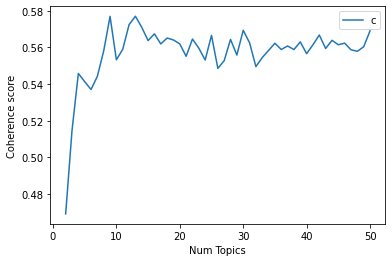

Num Topics = 2  has Coherence Value of 0.4691
Num Topics = 3  has Coherence Value of 0.5147
Num Topics = 4  has Coherence Value of 0.5458
Num Topics = 5  has Coherence Value of 0.5413
Num Topics = 6  has Coherence Value of 0.537
Num Topics = 7  has Coherence Value of 0.5443
Num Topics = 8  has Coherence Value of 0.5581
Num Topics = 9  has Coherence Value of 0.577
Num Topics = 10  has Coherence Value of 0.5533
Num Topics = 11  has Coherence Value of 0.559
Num Topics = 12  has Coherence Value of 0.5724
Num Topics = 13  has Coherence Value of 0.577
Num Topics = 14  has Coherence Value of 0.571
Num Topics = 15  has Coherence Value of 0.5637
Num Topics = 16  has Coherence Value of 0.5674
Num Topics = 17  has Coherence Value of 0.5619
Num Topics = 18  has Coherence Value of 0.5651
Num Topics = 19  has Coherence Value of 0.5641
Num Topics = 20  has Coherence Value of 0.5619
Num Topics = 21  has Coherence Value of 0.5552
Num Topics = 22  has Coherence Value of 0.5646
Num Topics = 23  has Coher

In [30]:
%%time 

import gensim
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import matplotlib.pyplot as plt


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Args:
  
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

    Returns:
    
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    
    for num_topics in range(start, limit, step):
        
        model = LdaMulticore(corpus=corpus,
                            id2word=dictionary,
                            num_topics=num_topics, 
                            random_state=42,
                            passes=10,
                            workers=7)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

data = pd.read_pickle("./data/cleaned_corpus.pkl")
texts = data['splitted_text'].to_list()
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=1000)
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=tfidf_corpus, texts=texts, start=2, limit=51, step=1)


limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

L’entrainement de l’ensemble des modèles a pris 24 minutes et 45 seconds soit environs 30 secondes par modèle.  Nous constatons que la cohérence maximale (0.6168) est atteinte avec 7 topics.

### Indices de log perplexité, de cohérence et du top 20 des tags les plus représentés par topic. 

In [31]:
%%time
from pprint import pprint
optimal_model = model_list[5]

print('\nPerplexity: ', optimal_model.log_perplexity(tfidf_corpus))

coherence_model_lda = CoherenceModel(model=optimal_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))


Perplexity:  -5.689641257134172

Coherence Score:  0.5442526190356581
[(0,
  '0.053*"json" + 0.038*"request" + 0.035*"http" + 0.034*"response" + '
  '0.027*"service" + 0.024*"error" + 0.024*"client" + 0.023*"test" + '
  '0.022*"post" + 0.018*"server" + 0.018*"application" + 0.017*"name" + '
  '0.017*"core" + 0.014*"config" + 0.014*"import" + 0.014*"root" + '
  '0.013*"class" + 0.013*"status" + 0.013*"access" + 0.013*"file" + '
  '0.012*"function" + 0.011*"message" + 0.011*"code" + 0.011*"return" + '
  '0.011*"property" + 0.011*"info" + 0.011*"body" + 0.011*"type" + '
  '0.010*"password" + 0.010*"context"'),
 (1,
  '0.104*"java" + 0.060*"android" + 0.046*"project" + 0.039*"studio" + '
  '0.036*"version" + 0.027*"support" + 0.027*"class" + 0.025*"google" + '
  '0.022*"error" + 0.021*"application" + 0.017*"package" + 0.016*"method" + '
  '0.015*"build" + 0.014*"name" + 0.014*"code" + 0.014*"import" + '
  '0.013*"source" + 0.013*"file" + 0.013*"anyone" + 0.012*"base" + '
  '0.011*"http" +

Nous constatons un nombre important de tags génériques dans ceux les plus représentés.

### Test du topic dominant, des mots clés associés des documents du corpus

In [32]:
%%time

original_post = data['Post']
original_cleaned_keywords = data['splitted_tags']

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=tfidf_corpus, texts=original_post)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

<timed exec>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


CPU times: total: 54.9 s
Wall time: 55.6 s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0.0,5.0,0.7923,"system, view, size, void, class, button, code,...",Why is processing a sorted array faster than p...,"[java, performance, architecture, branch, pred..."
1,1.0,4.0,0.5707,"database, query, item, javascript, table, conn...",How do I undo the most recent local commits in...,"[version, control, commit, undo]"
2,2.0,6.0,0.6700,"value, function, date, input, return, column, ...",How do I delete a Git branch locally and remot...,"[version, control, branch, push, remote]"
3,3.0,1.0,0.7077,"java, android, project, studio, version, suppo...","How do I force ""git pull"" to overwrite local f...","[version, control, overwrite, pull, fetch]"
4,4.0,6.0,0.6427,"value, function, date, input, return, column, ...",How do I revert a Git repository to a previous...,"[checkout, reset, revert]"
5,5.0,6.0,0.6652,"value, function, date, input, return, column, ...",How do I check out a remote Git branch? <p>Som...,"[checkout, remote, branch]"
6,6.0,0.0,0.6821,"json, request, http, response, service, error,...","How to make Git ""forget"" about a file that was...",[gitignore]
7,7.0,2.0,0.5711,"file, command, line, error, path, program, pyt...","What is the difference between ""px"", ""dip"", ""d...","[android, android, layout, user, interface, di..."
8,8.0,3.0,0.4469,"image, html, array, page, list, jquery, python...",How do I find all files containing specific te...,"[linux, text, grep, directory, find]"
9,9.0,0.0,0.7533,"json, request, http, response, service, error,...",What is the difference between POST and PUT in...,"[http, rest, post]"


### Document le plus significatif par topic

In [33]:
%%time

sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

CPU times: total: 15.6 ms
Wall time: 25 ms


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8710,"json, request, http, response, service, error,...",Wavy shape with css <p>I'm trying to recreate ...
1,1.0,0.8784,"java, android, project, studio, version, suppo...",TOAD for Oracle and Windows 7: Can't initializ...
2,2.0,0.8694,"file, command, line, error, path, program, pyt...",detect 404 error on page load <p>I am embeddin...
3,3.0,0.8593,"image, html, array, page, list, jquery, python...",NaN
4,4.0,0.8464,"database, query, item, javascript, table, conn...",Unit Testing HTTP traffic in Alamofire app <p>...
5,5.0,0.8582,"system, view, size, void, class, button, code,...",bash export command <p>I am encountering a str...
6,6.0,0.8510,"value, function, date, input, return, column, ...",Securing a password in a properties file <p>I ...


### Répartition des topics

Nous appréhendons tout d'abord la répartition des topics à l'aide d'un tableau;

In [34]:
%%time 
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_prop

CPU times: total: 15.6 ms
Wall time: 6 ms


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"json, request, http, response, service, error,...",4196,0.1217
1.0,1.0,"java, android, project, studio, version, suppo...",4489,0.1302
2.0,2.0,"file, command, line, error, path, program, pyt...",6335,0.1838
3.0,3.0,"image, html, array, page, list, jquery, python...",5939,0.1723
4.0,4.0,"database, query, item, javascript, table, conn...",3223,0.0935
5.0,5.0,"system, view, size, void, class, button, code,...",3799,0.1102
6.0,6.0,"value, function, date, input, return, column, ...",6492,0.1883


Nous ajoutons une visualisation spaciale des topics.

In [35]:
%%time

from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, tfidf_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_tfidf.html')
display(HTML('lda_tfidf.html'))

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: total: 5.25 s
Wall time: 7.61 s


En observant le tableau et le diagramme nous voyons que les documents sont répartis de manière assez égale hormis le topic 6 (sous-représenté à 9,72%) et le topic 7 (sur-représenté à 20,60%). Hormis le topic 7, des noms de technologies font partie des dix mots clés les plus représentés. 

Nous constatons cependant un nombre important de mots clés génériques associés à chaque topic comme par exemple error, number ou class. Enfin, les topics 1 et 3 ainsi que 2 et 4 ont de petites zones de recoupement.

### Fonction de prédiction

La fonction de prédiction des tags que nous avons construisons retourne les 20 mots les plus représentés du topic le plus représenté du texte soumis au modèle. A l’image de l’approche supervisée nous filtrons les résultats en ne gardant que les mots clés présents dans le texte soumis. 

A noter que l’approche non supervisée ne nécessite que de maintenir, en plus du TF-IDF le modèle LDA ainsi qu’un vocabulary (dictionnaire de correspondance) lié au corpus.

In [36]:
lda_model = optimal_model
def predict_unsupervised_tags(text):
    """
    Predict tags of a preprocessed text
    
    Args:
        text(list): preprocessed text
        
    Returns:
        relevant_tags(list): list of tags
    """
    
    corpus_new = id2word.doc2bow(text)
    topics = lda_model.get_document_topics(corpus_new)
    
    #find most relevant topic according to probability
    relevant_topic = topics[0][0]
    relevant_topic_prob = topics[0][1]
    
    for i in range(len(topics)):
        if topics[i][1] > relevant_topic_prob:
            relevant_topic = topics[i][0]
            relevant_topic_prob = topics[i][1]
            
    #retrieve associated to topic tags present in submited text
    potential_tags = lda_model.get_topic_terms(topicid=relevant_topic, topn=20)
    
    relevant_tags = [id2word[tag[0]] for tag in potential_tags if id2word[tag[0]] in text]
    
    return relevant_tags

### Fonction de vérification

Nous mettons à jour la fonction de vérification afin de comparer pour un document les tags renseignés par les utilisateurs et ceux prédit par les approches supervisées et non supervisée. 

Nous la testons sur les premiers documents du corpus.

In [37]:
def check_tag_predction(original_text, original_tags, preprocessed_text, supervised_model):
    """
    Check original tags vs predicted tags for a post.
    
    Args:
        post(list) : original text
        original_tags(list) : preprocessed_tags
    """
    
    predicted_supervised_tags = predict_supervised_tags(supervised_model, mlb, preprocessed_text)
    predicted_unsupervised_tags = predict_unsupervised_tags(preprocessed_text)
    print("Publication originale: \n")
    print(f"{original_text}")
    print("\n")
    print(f"Liste des tags pré-traités utilisés par l'utilisateur: {original_tags}")
    print("\n")
    print(f"Liste des tags prédits par le modèle supervisé: {predicted_supervised_tags}")
    print("\n")
    print(f"Liste des tags prédits par le modèle non supervisé: {predicted_unsupervised_tags}")

print("Test des 10 premiers documents du corpus\n")
for i in range(10):
    print(f"Document {i}:")
    print("\n")
    check_tag_predction(filtered_tokenized_vs_original.loc[i,'Post'], 
                    filtered_tokenized_vs_original.loc[i,'splitted_tags'],
                    filtered_tokenized_vs_original.loc[i,'splitted_text'],
                    svm_clf)
    print("-"*100 + "\n")

Test des 10 premiers documents du corpus

Document 0:


Publication originale: 

Why is processing a sorted array faster than processing an unsorted array? <p>Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data miraculously makes the code almost six times faster:</p>
<pre class="lang-cpp prettyprint-override"><code>#include &lt;algorithm&gt;
#include &lt;ctime&gt;
#include &lt;iostream&gt;

int main()
{
    // Generate data
    const unsigned arraySize = 32768;
    int data[arraySize];

    for (unsigned c = 0; c &lt; arraySize; ++c)
        data[c] = std::rand() % 256;

    // !!! With this, the next loop runs faster.
    std::sort(data, data + arraySize);

    // Test
    clock_t start = clock();
    long long sum = 0;
    for (unsigned i = 0; i &lt; 100000; ++i)
    {
        for (unsigned c = 0; c &lt; arraySize; ++c)
        {   // Primary loop
            if (data[c] &gt;= 128)
                sum += data[c];
        }
   

Si nous n’avons pas pu pas comparer les performances des approches supervisées et non supervisées sur des indicateurs communs nous avons comparé les prédictions des deux modèles  retenus aux tags initiaux renseignés par des utilisateurs sur dix documents. 

Sur un nombre aussi restreint de tests empiriques il serait hasardeux de tirer des conclusions quant aux choix d’un modèle. Nous notons néanmoins, qu’à une exception près pour chacun d’eux, que les deux modèles ont retourné des tags cohérents avec ceux initialement renseigné par les utilisateurs . 
Au-delà des prédictions, il s’avère que l’approche non supervisée est soumise à moins de contraintes que l’approche supervisée. En effet l’approche supervisée nécessite un travail plus important sur le dimensionnement des données et leur pré-traitement avant entrainement. De plus cette approche nécessite de maintenir plus de ressources (modèle de PCA,  modèle de vectorisation des tags, SVM) que l’approche non supervisée (modèle LDA et vocabulary). Pour ces raisons nous privilégions l’approche non supervisée. Nous intégrons toutefois les deux approches dans l’API à titre d’illustration.

Nous sauvegardons enfin le modèle LDA.

In [38]:
import pickle 

filename_model = './models/lda_model.pkl'
pickle.dump(lda_model, open(filename_model,'wb'))

filename_dictionary = './models/dictionary.pkl'
pickle.dump(id2word, open(filename_dictionary,'wb'))

Les livrables sont disponibles en ligne :
- [Repository de travaux de pré-traitement des documents et entrainement des modèles](https://github.com/viczer/IML/tree/main/P5_draft_v3)
- [Repository de l’API](https://github.com/viczer/API_stackoverflow)
- [Documentation de l’API](https://stackoverflowtagspredict.herokuapp.com/docs)
- [Endepoint de l’API](https://stackoverflowtagspredict.herokuapp.com/predict)
